In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, confusion_matrix 
from sklearn import svm
import seaborn as sns

## improve speed by limiting max columns shown at once
pd.set_option('display.max_columns', 50)

### Merge the match data from 2000-2020

In [42]:
frames = []

# Add games from years 2000-2020
for year in range(2000, 2021):
    frames.append(pd.read_csv(f"./data/matches_{year}.csv"))

df = pd.concat(frames)

### Clean up the data

In [43]:
## irrelevant columns
irr_cols = []
player_cols = ["ace", "df", "svpt", "1stIn", "1stWon", "2ndWon", "SvGms", "bpSaved", "bpFaced"]
general_cols = ["winner_name", "tourney_name", "loser_name", "winner_ioc", "loser_ioc", "minutes", "score", "draw_size", "round", "loser_seed", "loser_entry", "loser_rank_points", "winner_rank_points", "winner_seed", "winner_entry", "match_num", "tourney_id", "tourney_level", "best_of"]
## add winner/loser cols
for el in player_cols:
    irr_cols.append(f"w_{el}")
    irr_cols.append(f"l_{el}")

## add the general cols
irr_cols.extend(general_cols)

## drop irrelevant cols
df.drop(columns=irr_cols, inplace=True)

## calculate mean height of the players and replace null values with it
mean_ht = (df["winner_ht"].mean() + df["loser_ht"].mean()) / 2
df.loc[df["winner_ht"].isnull(), "winner_ht"] = mean_ht
df.loc[df["loser_ht"].isnull(), "loser_ht"] = mean_ht

## drop empty values
df.dropna(axis=0, inplace=True)

### Convert numerical values to floats

In [44]:
numeric_cols = ["winner_rank", "loser_rank", "winner_age", "loser_age", "winner_ht", "loser_ht"]
df[numeric_cols] = df[numeric_cols].astype(float)

### Adjust the dataset for performing predictions

In [45]:
## replace winner/loser with player1 & 2
for (colName, colData) in df.iteritems():
    if "winner" in colName:
        endingVal = colName.split("_")[1]
        df.rename(columns={colName: f"player1_{endingVal}"}, inplace=True)
    elif "loser" in colName:
        endingVal = colName.split("_")[1]
        df.rename(columns={colName: f"player2_{endingVal}"}, inplace=True)


## swap the labels for half of the values

first_half, second_half = df[:int(len(df) / 2)], df[int(len(df) / 2):]
first_half.insert(loc=0, column="label", value=1)

## swap columns
scols = list(second_half.columns)

np.warnings.filterwarnings('ignore')

## swap the columns for the second half
for attr in ["id", "hand", "ht", "age", "rank"]:
    scols[scols.index(f"player1_{attr}")], scols[scols.index(f"player2_{attr}")] = scols[scols.index(f"player2_{attr}")], scols[scols.index(f"player1_{attr}")]
    # second_half.insert(loc=0, column="label", value=0)
    second_half["label"] = 0

halves = []

df = pd.concat([first_half, second_half])


### Visualize data

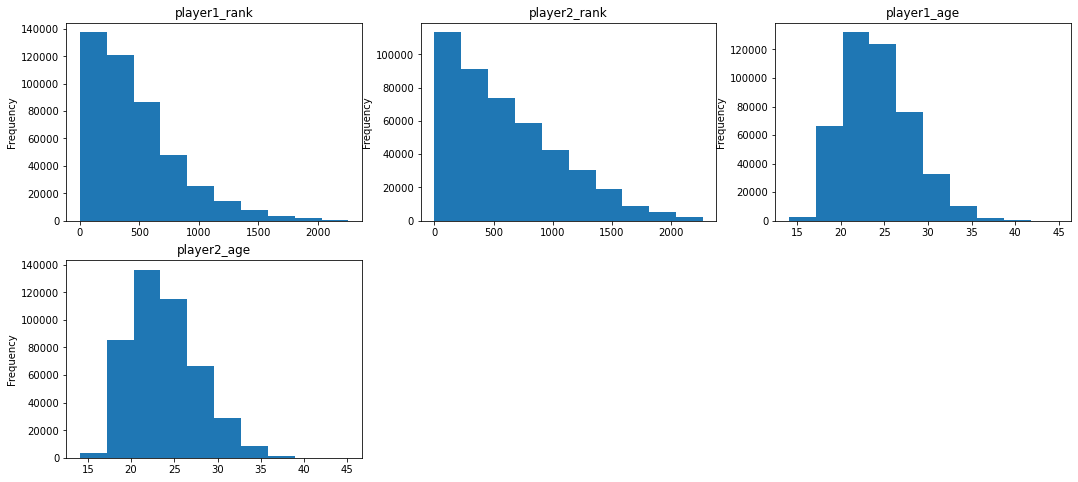

In [46]:
cols = ["player1_rank", "player2_rank", "player1_age", "player2_age"]

plt.figure(1, figsize=(18, 8))

for i in range(len(cols)):
    plt.subplot(2, 3, i + 1)
    df[cols[i]].plot(kind="hist", title=cols[i])

plt.show()

### Prepare data for ML models

In [47]:
## convert categorical values (player hand, surface) to numbers
le = LabelEncoder()
df["surface"] = le.fit_transform(df["surface"])
df["player1_hand"] = le.fit_transform(df["player1_hand"])
df["player2_hand"] = le.fit_transform(df["player2_hand"])

## features that will be used in the model
features = ["player1_ht", "player2_ht", "player1_age", "player2_age", "player1_rank", "player2_rank", "surface", "player1_hand", "player2_hand"]
X = df[features]
y = df["label"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


### Logistic Regression

In [48]:
clf_1 = LogisticRegression()

## training the model
clf_1.fit(X_train, y_train)
y_pred_train_1 = clf_1.predict(X_train)
acc_train_1 = clf_1.score(X_train, y_train)
accuracy_1 = clf_1.score(X, y)

## validation
y_pred_val_1 = clf_1.predict(X_val)
acc_val_1 = clf_1.score(X_val, y_val)

print(f"training accuracy: {acc_train_1}")
print(f"validation accuracy: {acc_val_1}")

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1

### Confusion matrix

In [ ]:
conf_mat = confusion_matrix(y, np.concatenate([y_pred_train_1, y_pred_val_1]))

## calculate the precision by dividing TP by (TP + FP)
## it denotes the proportion of true positives in total positives
true_pos = conf_mat[1][1]
false_pos = conf_mat[0][1]
precision = true_pos / (true_pos + false_pos)

print(f"precision: {precision}")

### Visualize

In [ ]:
ax = plt.subplot()
sns.heatmap(conf_mat, annot=True, fmt='g', ax=ax)

fontsize = 14

ax.set_title("Confusion matrix", fontsize=fontsize)
ax.set_xlabel("Predictions", fontsize=fontsize)
ax.set_ylabel("True values", fontsize=fontsize)
ax.xaxis.set_ticklabels(["L", "W"], fontsize=fontsize)
ax.yaxis.set_ticklabels(["L", "W"], fontsize=fontsize)